AI - TP3_8

Bastien SAUVAT et Bastien FAISANT

# Exercise 3 : Mini-project : Image to text description

### Image Caption Generator using Flickr Dataset

#### Imports modules

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = '.\\kaggle\\input\\flickr8k'
WORKING_DIR = '.\\kaggle\\working'

#### Extract Images Features

In [4]:
model = VGG16() #load vgg16 model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

****

#### Load the Captions Data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, image_caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = ' '.join(image_caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

#### Preprocessing Text Data

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[Â-Za-z]+', '')
            caption = caption.replace('\s+', ' ')
            caption = '<start>' + ' '.join([word for word in caption.split() if len(word)>1]) + '<end>'
            captions[i] = caption

In [11]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
clean(mapping)

In [13]:
mapping['1000268201_693b08cb0e']

['<start>child in pink dress is climbing up set of stairs in an entry way<end>',
 '<start>girl going into wooden building<end>',
 '<start>little girl climbing into wooden playhouse<end>',
 '<start>little girl climbing the stairs to her playhouse<end>',
 '<start>little girl in pink dress going into wooden cabin<end>']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['<start>child in pink dress is climbing up set of stairs in an entry way<end>',
 '<start>girl going into wooden building<end>',
 '<start>little girl climbing into wooden playhouse<end>',
 '<start>little girl climbing the stairs to her playhouse<end>',
 '<start>little girl in pink dress going into wooden cabin<end>',
 '<start>black dog and spotted dog are fighting<end>',
 '<start>black dog and tri-colored dog playing with each other on the road<end>',
 '<start>black dog and white dog with brown spots are staring at each other in the street<end>',
 '<start>two dogs of different breeds looking at each other on the road<end>',
 '<start>two dogs on pavement moving toward each other<end>']

In [17]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8483

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

33

#### Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
split
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# Create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

                

#### Model Creation

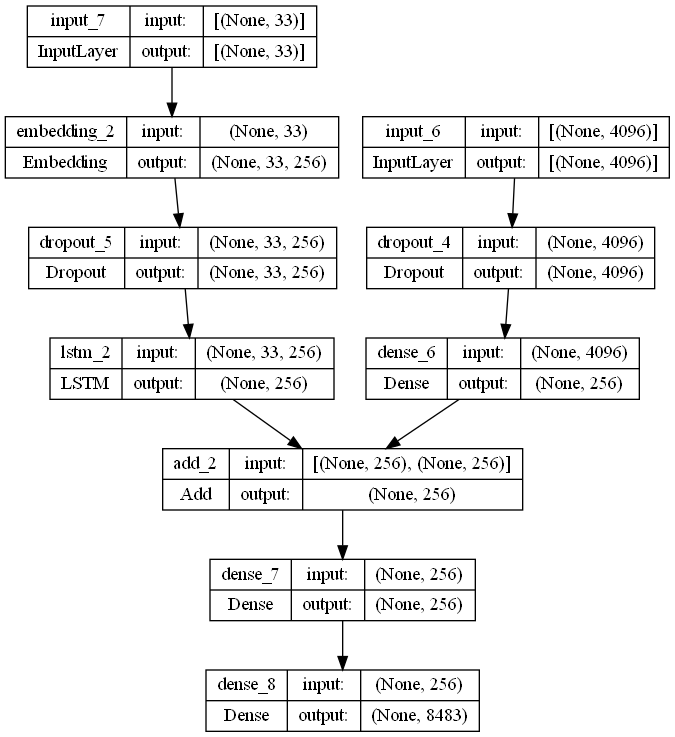

In [24]:
# encoder model
# image feature layer
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequuence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

### Utilisation de la bibliothethque Huggingface transformers avec un modèle pré-entrainé

In [1]:
from transformers import pipeline

In [2]:
captioner = pipeline("image-to-text",model="Salesforce/blip-image-captioning-base")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/990M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
captioner("https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png")